In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch

from dgp import get_dataloader

import torch.nn.functional as F
from utils import move_to_device


from utils.llc import calculate_llc_for_file, evaluate_fn

from utils.loading import load_model_from_hf

from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset

from utils.loading import Conf

from utils.default_device import get_default_device

from functools import partial

In [2]:
hf_repo_name = "cybershiptrooper/ConceptPerlocation_ckpts_98k"
model_dir = f'results/scratch/{hf_repo_name}'
model = load_model_from_hf(0, hf_repo_name, epoch=0)
config = Conf(**model["config"])
# config.device = get_default_device()
config.device = "cpu"

/Users/cybershiptrooper/src/interpretability/devinterp/ConceptPercolation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cybershiptrooper/src/interpretability/devinterp/ConceptPercolation/utils/loading.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expli

In [5]:
dataloader = get_dataloader(
    n_relative_properties=config.data.n_relative_properties,
    n_descriptive_properties=config.data.n_descriptive_properties,
    n_descriptive_values=config.data.n_descriptive_values,
    num_of_classes_to_divide_over=config.data.num_of_classes_to_divide_over,
    prior_param=config.data.prior_param,
    props_prior_type=config.data.props_prior_type,
    n_entities=config.data.n_entities,
    instr_ratio=config.data.instr_ratio,
    max_sample_length=config.data.max_sample_length,
    num_iters=config.data.num_iters * config.data.batch_size,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers,
    seed=config.seed,
    evaluation=True,
)

pad_token_id = dataloader.dataset.pad_token_id

evaluator = evaluate_fn

In [9]:
num_chains = 5
num_draws = 150
iteration = 20_000
gammas = [100.0, 200.0]
eps = [5e-4, 1e-3]
llcs = {}
# grid sweep
for e in eps:
    for g in gammas:
        print(f"e: {e}, g: {g}")
        llc = calculate_llc_for_file(
            iteration=iteration,
            dataloader=dataloader,
            model_dir=hf_repo_name,
            config=config,
            evaluate_fn=evaluator,
            model_loader=load_model_from_hf,
            num_chains=5,
            num_draws=200,
            vocab_size=dataloader.dataset.PCSG.vocab_size,
        )
        llcs[(e, g)] = llc

e: 0.0005, g: 100.0


Chain 4: 100%|██████████| 200/200 [00:23<00:00,  8.50it/s]


e: 0.0005, g: 200.0


Chain 4: 100%|██████████| 200/200 [00:22<00:00,  8.84it/s]


e: 0.001, g: 100.0


Chain 4: 100%|██████████| 200/200 [00:23<00:00,  8.35it/s]


e: 0.001, g: 200.0


Chain 4: 100%|██████████| 200/200 [00:22<00:00,  8.74it/s]


In [15]:
import pickle
dump_dir = f"./results/scratch/{hf_repo_name}/llc/"
grid_str = f"{len(eps)}_by_{len(gammas)}"
with open(f"{dump_dir}/icl1_sweep_it_{iteration}_draws_{num_draws}_{grid_str}.pkl", "wb") as f:
    pickle.dump(llcs, f)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Literal

def plot_trace(llcs, eps, gammas, version: Literal['normal', 'mean_std', 'min_max'] = 'normal', figsize=(20, 20)):
    _, ax = plt.subplots(len(eps), len(gammas), figsize=figsize)
    std, mean, mins, maxs = {}, {}, {}, {}
    
    for i, e in enumerate(eps):
        for j, g in enumerate(gammas):
            llc_output = llcs[(e, g)]
            traces = llc_output["loss/trace"]
            all_mean = np.mean(traces)
            ax[i, j].hlines(all_mean, 0, len(traces[0]),
                            color="red", linestyle="--", linewidth=2)
            if version == 'normal':
                cmap = plt.get_cmap("viridis")
                for color, chain in enumerate(traces):
                    ax[i, j].plot(chain, alpha=0.7, color=cmap(color / len(traces)))
            
            elif version == 'mean_std':
                # Calculate mean and standard deviation
                trace_mean = np.mean(traces, axis=0)
                trace_std = np.std(traces, axis=0)
                ax[i, j].plot(trace_mean, color="blue")
                ax[i, j].fill_between(
                    np.arange(len(trace_mean)),
                    trace_mean - trace_std,
                    trace_mean + trace_std,
                    color="blue",
                    alpha=0.3,
                )
                
            elif version == 'min_max':
                # Calculate min and max for traces
                trace_mean = np.mean(traces, axis=0)
                trace_min = np.min(traces, axis=0)
                trace_max = np.max(traces, axis=0)
                ax[i, j].plot(trace_mean, color="blue")
                ax[i, j].fill_between(
                    np.arange(len(trace_mean)),
                    trace_min,
                    trace_max,
                    color="blue",
                    alpha=0.3,
                )
                
            ax[i, j].set_title(f"e: {e}, g: {g}")

    # Set font size for all subplots
    for a in ax.flatten():
        a.tick_params(axis="both", which="major", labelsize=16)
        a.set_title(a.get_title(), fontsize=16)
    
    plt.tight_layout()
    plt.show()


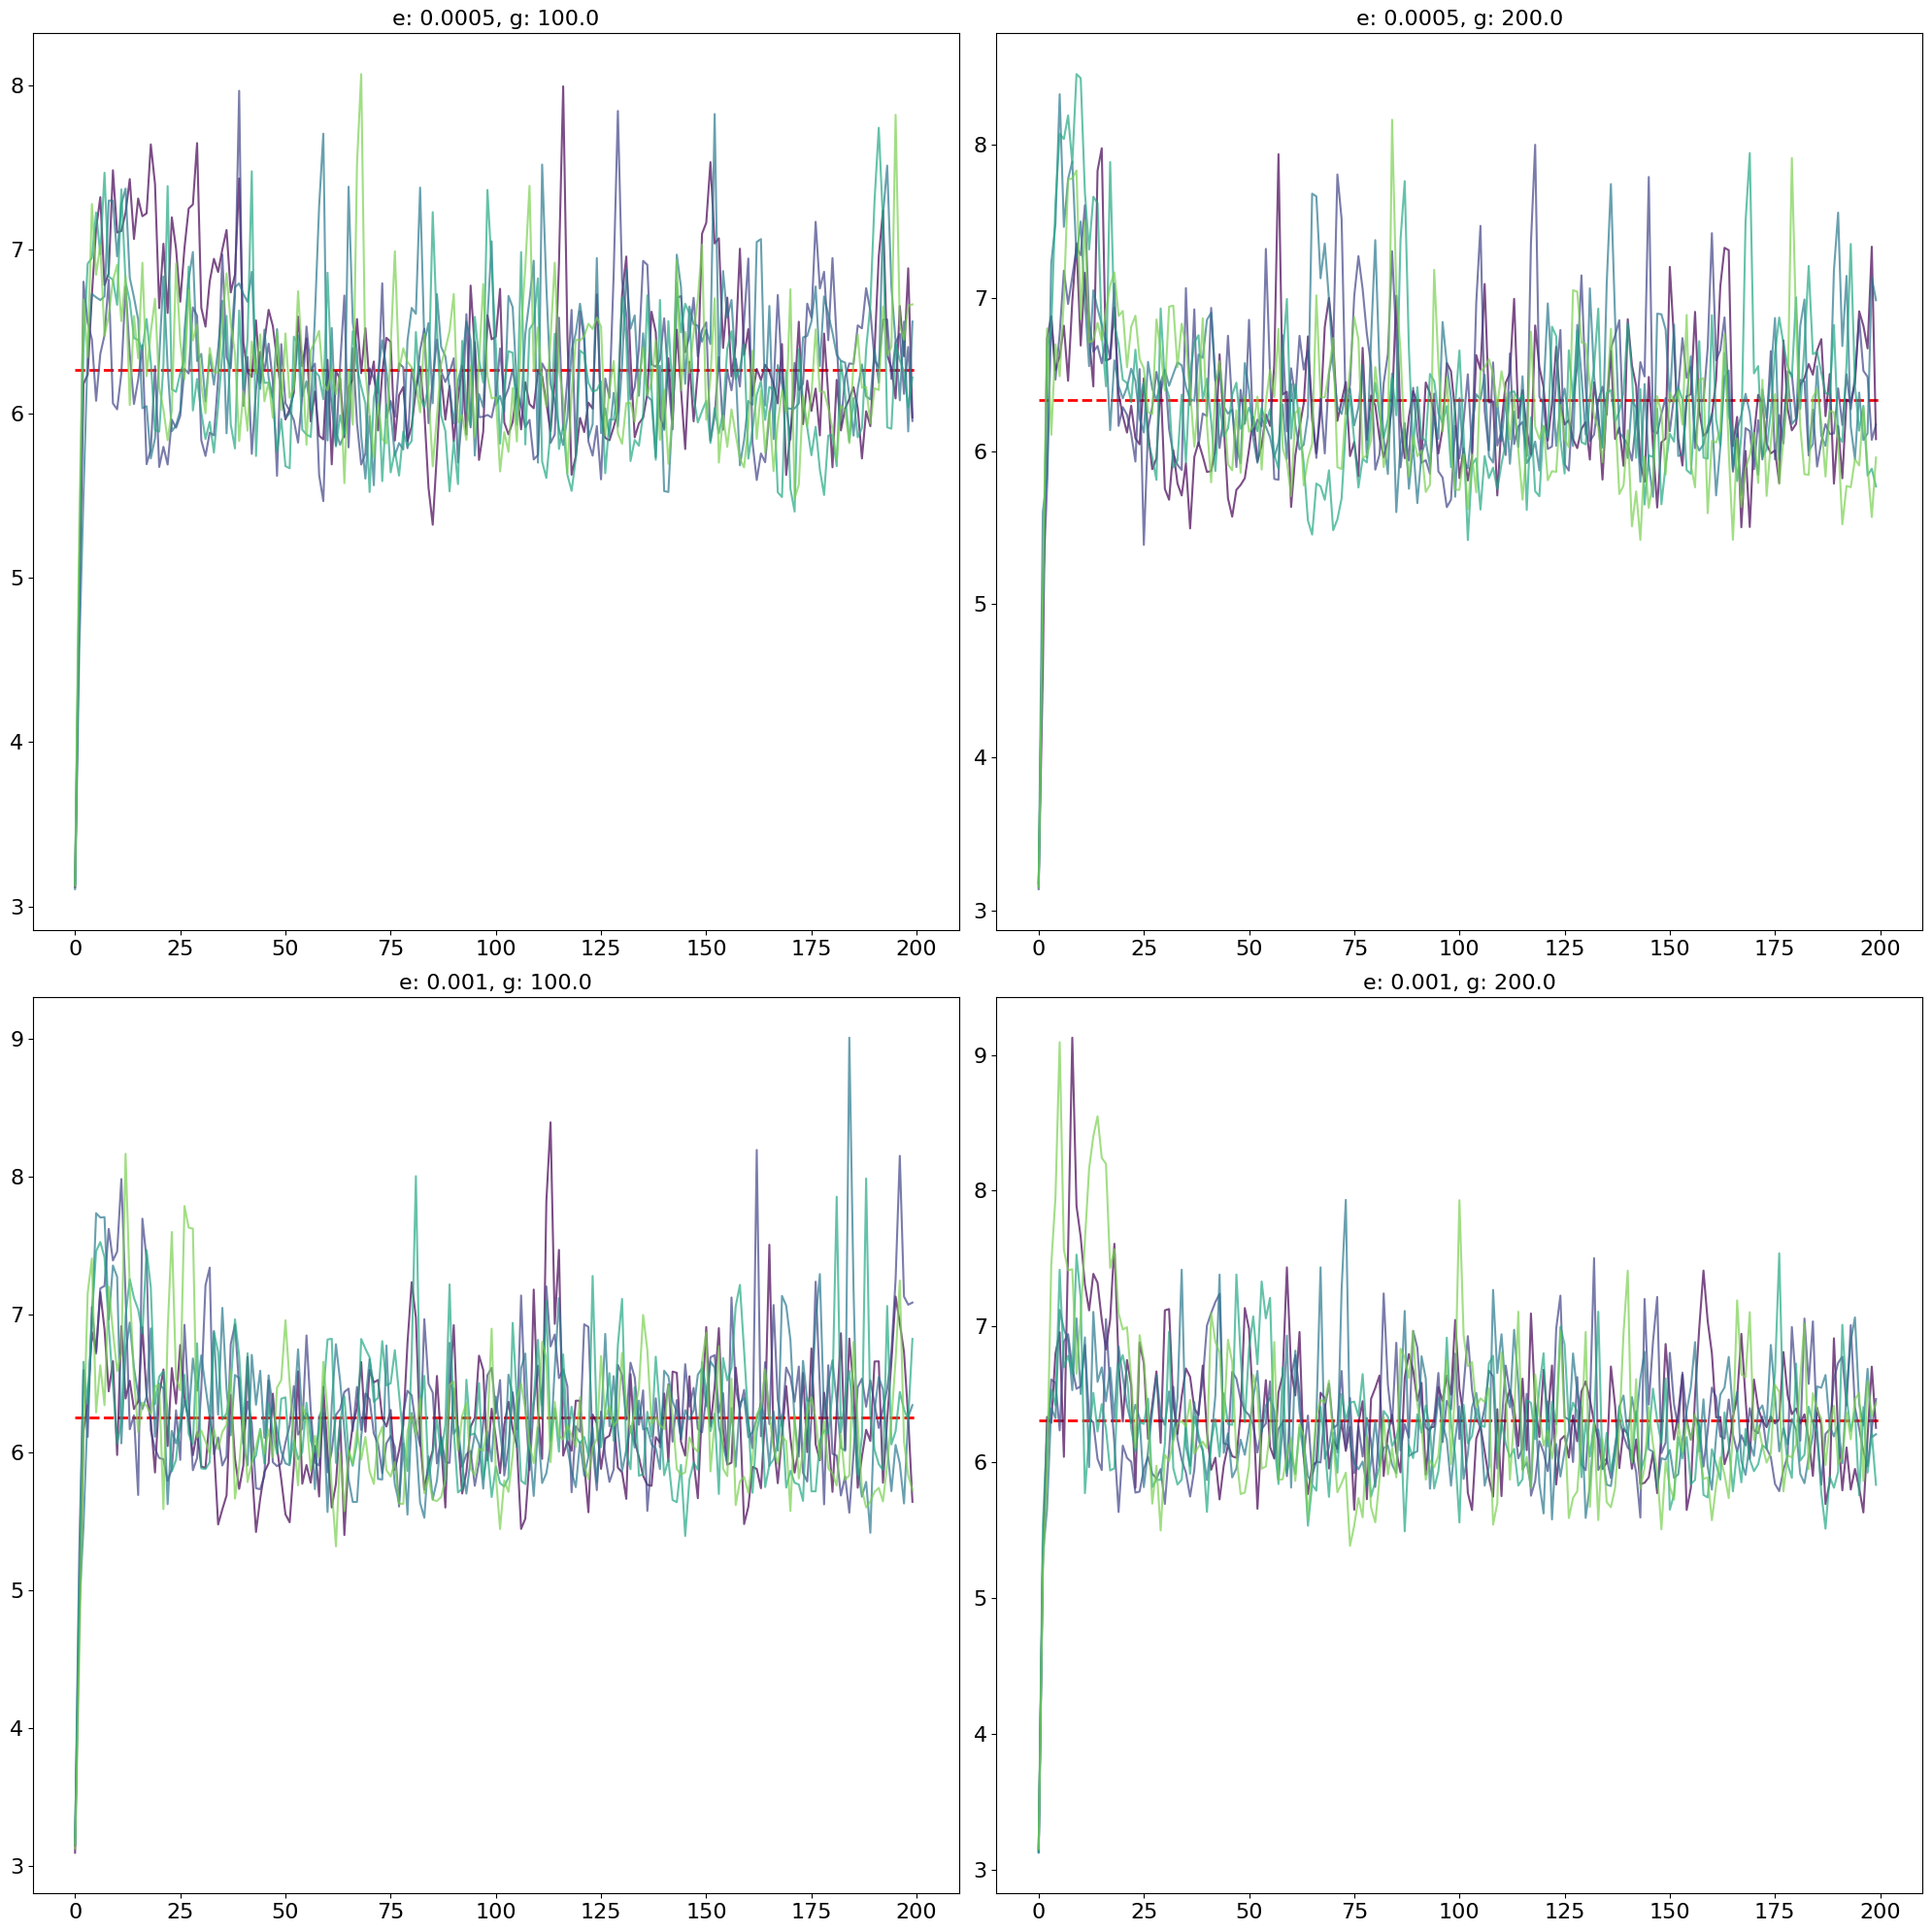

In [11]:
plot_trace(llcs, eps, gammas)

In [80]:
# plot chain average variance v/s mean 

def plot_variance_vs_mean(llcs, eps, gammas, figsize=(10, 10)):
    _, ax = plt.subplots(len(eps), len(gammas), figsize=figsize)
    for i, e in enumerate(eps):
        for j, g in enumerate(gammas):
            llc_output = llcs[(e, g)]
            traces = llc_output["loss/trace"]
            all_mean = np.mean(traces, axis=0)
            all_std = np.std(traces, axis=0)
            # ax[i, j].scatter(all_mean, all_std, color="blue", alpha=0.5, marker=".")

            # plot 1/snr curve
            snr = all_std / all_mean
            ax[i, j].scatter(all_mean, snr, color="red", alpha=0.5, marker=".")
            ax[i, j].set_title(f"e: {e}, g: {g}")
            ax[i, j].set_xlabel("Mean")
            
            # ax[i, j].legend(["Variance", "Variance/Mean"])

    plt.tight_layout()
    plt.show()

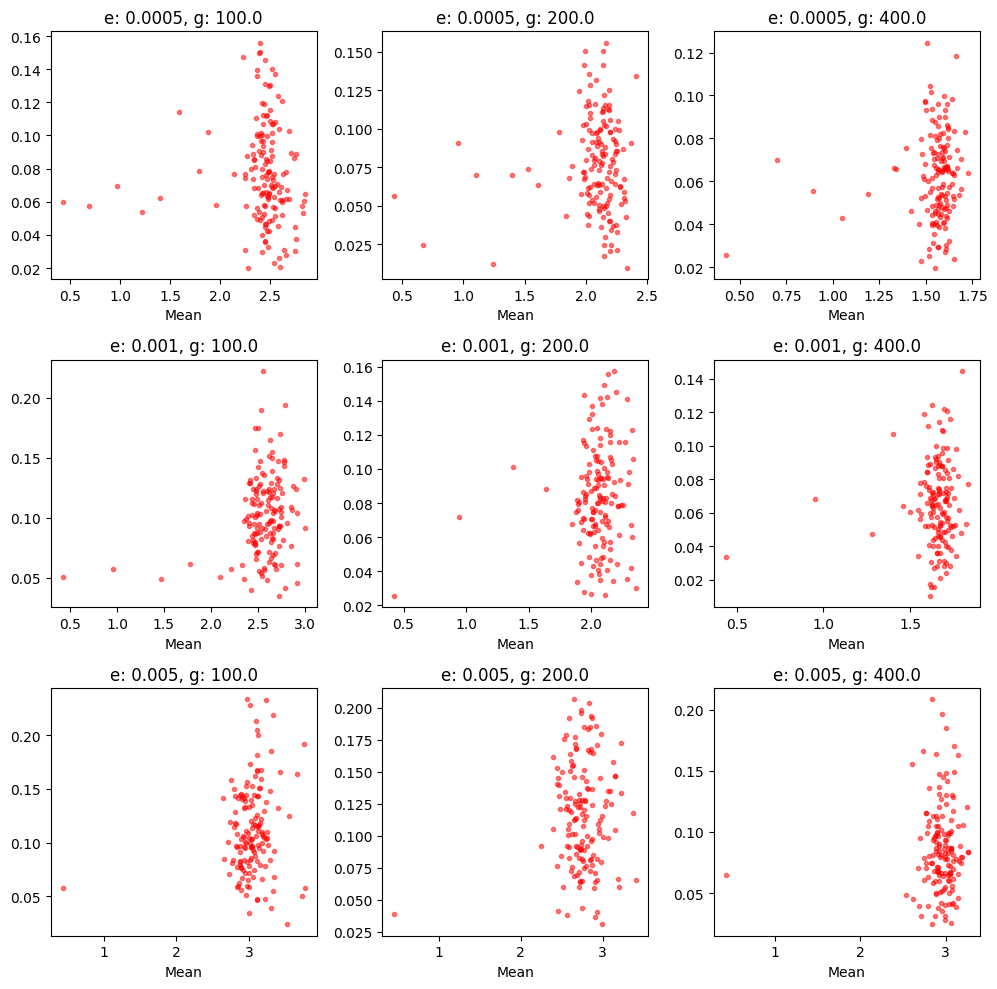

In [81]:
plot_variance_vs_mean(llcs, eps, gammas)

In [82]:
# plot chain average variance v/s mean as SNR for each (e, g) pair as a heatmap

def plot_normalised_stds(llcs, eps, gammas, llc = True):
    image_grid = np.zeros((len(eps), len(gammas)))
    for i, e in enumerate(eps):
        for j, g in enumerate(gammas):
            llc_output = llcs[(e, g)]
            traces = llc_output["loss/trace"]
            if llc:
                trace_mean = llc_output["llc/means"].mean() 
                trace_std = llc_output["llc/stds"].mean()
                nvar = trace_std / trace_mean
            else:
                trace_mean = np.mean(traces, axis=0)
                trace_std = np.std(traces, axis=0)
                nvar = (trace_std / (trace_mean + 1e-6)).mean()
            image_grid[i, j] = nvar
    plt.imshow(image_grid, cmap="viridis")
    plt.colorbar()
    plt.xticks(np.arange(len(gammas)), gammas)
    plt.yticks(np.arange(len(eps)), eps)
    plt.xlabel("Gamma")
    plt.ylabel("Epsilon")
    return image_grid

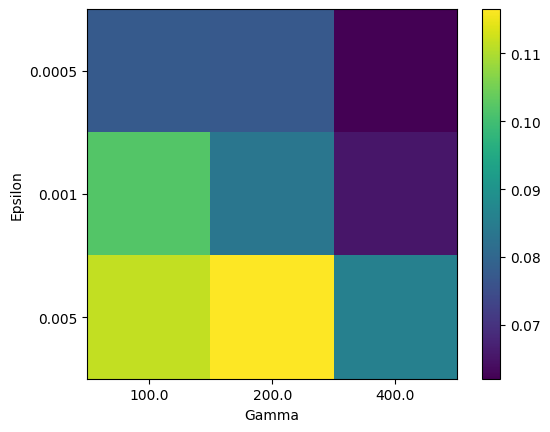

In [85]:
g1 = plot_normalised_stds(llcs, eps, gammas, False)

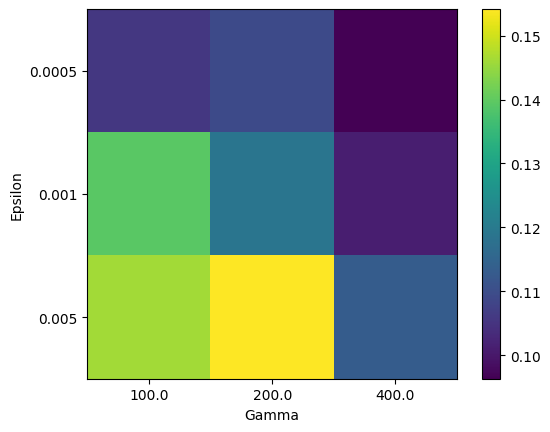

In [86]:
g2 = plot_normalised_stds(llcs, eps, gammas, True)

(array([[15.40446949, 16.46950722, 18.25614738],
        [11.06992054, 13.9885397 , 18.66320229],
        [10.46626282, 10.01978588, 13.90569687]]),
 array([[ 9.45362473,  9.14067936, 10.3819828 ],
        [ 7.18139172,  8.42200851,  9.88256454],
        [ 6.83881283,  6.48742676,  8.83362865]]))